# Báo cáo cuối kỳ Thị Giác Máy Tính


## I. Giới thiệu đề tài
Trong thời đại chuyển đổi số hiện nay, việc số hóa thông tin từ các tài liệu giấy tờ như căn cước công dân (CCCD) là một nhu cầu thiết yếu, phục vụ cho các hệ thống tự động hóa quản lý, định danh và lưu trữ dữ liệu. Tuy nhiên, các tài liệu này thường được chụp dưới nhiều điều kiện khác nhau (nghiêng, mờ, ánh sáng yếu...), dẫn đến việc xử lý tự động gặp nhiều thách thức.
1. Xác định 4 góc của căn cước công dân trong ảnh để xử lý ảnh.
2. Xác định vùng chứa chữ để trích xuất các trường dữ liệu của ảnh.
3. Nhận dạng ký tự trong từng vùng, nhằm số hóa nội dung.

Hệ thống được triển khai bằng mô hình YOLOv8 để xử lý các bước phát hiện góc và vùng chữ, kết hợp với Tesseract OCR cho bước nhận dạng ký tự. Đề tài cũng được tích hợp vào một hệ thống web demo gồm frontend Vue.js và backend FastAPI để thể hiện khả năng ứng dụng thực tiễn.

In [79]:
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## II. Giới thiệu về tập dữ liệu
Hình ảnh Căn Cước Công Dân được thu thập từ các nguồn như Roboflow, Kaggle, Internet và tự chụp

In [130]:
import yaml
import os

def describe_yolov8_dataset(data_yaml_path, dataset_title):
    def count_files(folder, ext):
        if not os.path.exists(folder):
            return 0
        return len([f for f in os.listdir(os.path.join(folder, 'images')) if f.lower().endswith(ext)])

    with open(data_yaml_path, "r") as f:
        data = yaml.safe_load(f)

    root_path = os.path.dirname(data_yaml_path)

    train_path = os.path.join(root_path, 'train')
    val_path = os.path.join(root_path, 'valid')
    test_path = os.path.join(root_path, 'test')

    train_images = count_files(train_path, ('.jpg', '.jpeg', '.png'))
    val_images = count_files(val_path, ('.jpg', '.jpeg', '.png'))
    test_images = count_files(test_path, ('.jpg', '.jpeg', '.png')) if os.path.exists(test_path) else 0

    print(f"Mô tả tập dữ liệu {dataset_title}")
    print(f"Đường dẫn: {root_path}")
    print(f"- Số lớp: {data['nc']} | {data['names']}")
    print(f"- Số ảnh tập train: {train_images} ảnh")
    print(f"- Số ảnh tập val: {val_images} ảnh")
    if os.path.exists(test_path):
        print(f"- Số ảnh tập test: {test_images} ảnh,")



### 1. Tập dữ liệu để xác định 4 góc của căn
Tập dữ liệu này được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>top-left</li>
    <li>top-right</li>
    <li>bottom-left</li>
    <li>bottom-right</li>
</ul>

Link dữ liệu đã gán nhán: <a href="https://app.roboflow.com/socialv2/cornerdetection-vsjvm/models">https://app.roboflow.com/socialv2/cornerdetection-vsjvm/models</a>

In [131]:
CORNER_DATA_PATH = './corner_dataset/data.yaml'
describe_yolov8_dataset(CORNER_DATA_PATH, 'corder_dataset')

Mô tả tập dữ liệu corder_dataset
Đường dẫn: ./corner_dataset
- Số lớp: 4 | ['bottom-left', 'bottom-right', 'top-left', 'top-right']
- Số ảnh tập train: 370 ảnh
- Số ảnh tập val: 105 ảnh
- Số ảnh tập test: 53 ảnh,


### 2. Tập dữ liệu để xác định (Mặt trước)
Tập dữ liệu này cũng được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>id</li>
    <li>full_name</li>
    <li>date_of_birth</li>
    <li>sex</li>
    <li>nationality</li>
    <li>place_of_origin</li>
    <li>place_of_residence</li>
    <li>date_of_expiry</li>
    <li>qr_code</li>
</ul>

In [133]:
FRONT_FIELD_DATA_PATH = './front_cccd_dataset/front-field-data.yaml'
describe_yolov8_dataset(FRONT_FIELD_DATA_PATH, 'front-cccd-dataset')

Mô tả tập dữ liệu front-cccd-dataset
Đường dẫn: ./front_cccd_dataset
- Số lớp: 9 | ['id', 'full_name', 'date_of_birth', 'sex', 'nationality', 'place_of_origin', 'place_of_residence', 'date_of_expiry', 'qr_code']
- Số ảnh tập train: 1693 ảnh
- Số ảnh tập val: 172 ảnh
- Số ảnh tập test: 59 ảnh,


### 3. Tập dữ liệu để xác định (Mặt sau)
Tập dữ liệu này cũng được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>fingerprint</li>
    <li>issue_date</li>
    <li>issue_place</li>
    <li>personal_identification</li>
</ul>
Link dữ liệu đã gán nhán: <a href="https://app.roboflow.com/socialv2/backcccd/7">https://app.roboflow.com/socialv2/backcccd/7</a>

In [134]:
BACK_FIELD_DATA_PATH = './back_cccd_dataset/data.yaml'
describe_yolov8_dataset(BACK_FIELD_DATA_PATH, 'back-cccd-dataset')

Mô tả tập dữ liệu back-cccd-dataset
Đường dẫn: ./back_cccd_dataset
- Số lớp: 4 | ['fingerprint', 'issue_date', 'issue_place', 'personal_identification']
- Số ảnh tập train: 137 ảnh
- Số ảnh tập val: 33 ảnh


## III. Kỹ thuật tăng cường dữ liệu
Trong quá trình huấn luyện, để cải thiện khả năng tổng quát hóa của mô hình và giảm hiện tượng overfitting, các kỹ thuật sau đây đã được áp dụng trong bài toán.

<ul>
    <li>Điều chỉnh sắc độ (Hue) trong không gian màu HSV để tạo ra màu sắc đa dạng.</li>
    <li>Điều chỉnh độ bão hòa (Saturation), làm ảnh tươi hoặc nhạt hơn.</li>
    <li>Điều chỉnh độ sáng (Brightness) của ảnh.</li>
    <li>Xoay ảnh trong khoảng ±10 độ, giúp mô hình học được các biến dạng do xoay.</li>
    <li>Tịnh tiến ảnh theo cả trục x và y với độ lệch tối đa là 10%</li>
    <li>Phóng to hoặc thu nhỏ ảnh lên đến ±50% để mô hình không phụ thuộc vào kích thước đối tượng.</li>
    <li>Biến dạng hình học bằng phép xiên (shear) ảnh ±2 độ.</li>
    <li>Xác suất lật ảnh theo chiều dọc là 50%.</li>
    <li>Xác suất lật ảnh theo chiều ngang là 50% – thường dùng cho ảnh chứa chữ.</li>
    <li>Áp dụng kỹ thuật Mosaic Augmentation – kết hợp 4 ảnh thành 1 để tăng tính đa dạng bối cảnh.</li>
    <li>Áp dụng kỹ thuật MixUp – trộn hai ảnh cùng nhãn với tỷ lệ 20% để làm mượt biên nhãn.</li>
</ul>

In [59]:
augment_params = dict(
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
)

## IV. Mô hình
### 1. Mô hình đề xuất
Mô hình YOLOv8 (You Only Look Once version 8) – một trong những mô hình phát hiện đối tượng (object detection) hiện đại và mạnh mẽ nhất hiện nay, được phát triển bởi Ultralytics.


In [232]:
from abc import ABC
from ultralytics import YOLO
import os
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

class BaseDetector(ABC):
    def __init__(self, model, save_dir):
        self.model = YOLO(model)
        self.save_dir = save_dir
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def train(self, data, epochs, imgsz, batch, patience, freeze, augment_params):
        if not os.path.exists(data):
            raise FileNotFoundError(f"Không tìm thấy file {data}. Hãy kiểm tra đường dẫn!")
        
        if freeze is not None:
            self.freeze_layer(self.model, num_freeze=freeze)

        self.model.train(
            data=data,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            device=self.device,
            patience=patience,
            amp=True,
            augment=True,
            **augment_params
        )

    def predict(self, img):
        return self.model(img, verbose=False)

    def freeze_layer(self, trainer, num_freeze):
        model = trainer.model
        freeze = [f'model.{x}.' for x in range(num_freeze)]
        for k, v in model.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
        print(f"✅ {num_freeze} layers frozen successfully.")

    def evaluate(self, data):
        metrics = self.model.val(data=data, project=self.save_dir )
        return {
            "mean_mAP50": np.mean(metrics.box.map50),
            "mean_mAP50-95": np.mean(metrics.box.map),
            "mean_precision": np.mean(metrics.box.mp),
            "mean_recall": np.mean(metrics.box.mr)
        }

    def plot_loss_history(self):
        try:
            history = self.model.trainer.metrics
            if not history:
                print("No training history found. Train the model first.")
                return

            epochs = range(len(history["train/box_loss"]))
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, history["train/box_loss"], label="Box Loss")
            plt.plot(epochs, history["train/obj_loss"], label="Obj Loss")
            if "train/cls_loss" in history:
                plt.plot(epochs, history["train/cls_loss"], label="Cls Loss")

            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training Loss History")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        except AttributeError:
            print("Model has no training history available.")

    def plot_val_results(self, data, normalize=True, figsize=(16, 12), max_images=6):
        image_paths = glob.glob(os.path.join(self.save_dir,'val', "*.png"))
        print(image_paths)
        image_paths = sorted(image_paths)[:max_images]

        if not image_paths:
            print("No result images found in validation output directory.")
            return

        n_images = len(image_paths)
        cols = 3
        rows = (n_images + cols - 1) // cols

        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        axs = axs.flatten()

        for i, image_path in enumerate(image_paths):
            img = Image.open(image_path)
            axs[i].imshow(img)
            axs[i].set_title(os.path.basename(image_path))
            axs[i].axis("off")

        for j in range(i + 1, len(axs)):
            axs[j].axis("off")

        plt.tight_layout()
        plt.show()

    def save(self, out="best_model.pt"):
            self.model.save(out)

    def get_model(self):
        return self.model
    
    def print_summary(self):
        print(self.model)
        self.model.info()

### 2. Mô hình phát hiện góc của CCCD
#### 2.1 CorderDetector (sử dụng yolov8n.pt)

In [251]:
class CornerDetector(BaseDetector):
    def __init__(self, model="yolov8n.pt"):
        super().__init__(model=model, save_dir='corner-project-runs')

In [252]:
corner_detector = CornerDetector()

#### 2.2 Trực quan model
- 129 lớp
- 3,157,200 tham số

In [25]:
corner_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### 3. Mô hình phát hiện vùng văn bản mặt trước CCCD
#### 3.1 FrontFieldDetector (sử dụng yolov8l.pt)

In [233]:
class FrontFieldDetector(BaseDetector):
    def __init__(self, model="yolov8l.pt"):
        super().__init__(model=model, save_dir='front-field-project-runs')

In [220]:
front_field_detector = FrontFieldDetector()

#### 3.2 Trực quan model
- 209 lớp
- 43,691,520 tham số

In [53]:
front_field_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_r

### 4. Mô hình phát hiện vùng văn bản mặt sau CCCD
#### 4.1 BackFieldDetector (sử dụng yolov8n.pt)

In [237]:
class BackFieldDetector(BaseDetector):
    def __init__(self, model="yolov8n.pt"):
        super().__init__(model=model, save_dir='back-field-project-runs')

In [238]:
back_field_detector = BackFieldDetector()

#### 4.2 Trực quan model

In [191]:
back_field_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

## V. Huấn luyện mô hình


### 2. Tham số huấn luyện
- <strong>Thiết bị GPU</strong>: cuda
- <strong>Số epochs</strong>: 100
- <strong>Kích thước batch</strong>: 16
- <strong>Kích thước đầu vào</strong>: (640x640)

In [62]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30
BATCH_SIZE = 16
IMG_SIZE = 640

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU name: NVIDIA GeForce RTX 3060


### 3. Quá trình huấn luyện

#### 3.1. Huấn luyện mô hình phát hiện góc

In [246]:
FRONT_FIELD_DATA_PATH = 'corner_dataset/data.yaml'
SAVED_CORNER_MODEL = "corner_model_final.pt"

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

corner_detector.train(**training_params)
corner_detector.save(SAVED_CORNER_MODEL)

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=corner_dataset/data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning /home/social-v2/CV_Project/corner_dataset/train/labels.cache... 370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/social-v2/CV_Project/corner_dataset/valid/labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]


Plotting labels to /home/social-v2/CV_Project/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/social-v2/CV_Project/runs/detect/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.06G      2.691      4.528      1.594          7        640: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        105        402   0.000666     0.0296    0.00291    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.06G      2.054      2.731      1.208          9        640: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        105        402      0.626      0.195      0.436      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.06G      1.876      2.141      1.215         13        640: 100%|██████████| 24/24 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        105        402      0.647      0.336       0.54      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.06G      1.818      1.898      1.176          6        640: 100%|██████████| 24/24 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        105        402      0.645      0.622      0.738      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.06G       1.76      1.751      1.162         10        640: 100%|██████████| 24/24 [00:04<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        105        402      0.578      0.789      0.759      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.06G      1.723      1.627      1.127          8        640: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        105        402      0.689      0.765      0.784      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.06G      1.682      1.532      1.132         10        640: 100%|██████████| 24/24 [00:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        105        402      0.732       0.83      0.812      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.06G      1.663      1.507      1.122          6        640: 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        105        402      0.706      0.857      0.864      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.08G      1.597      1.439      1.092          9        640: 100%|██████████| 24/24 [00:04<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        105        402      0.852      0.869      0.887      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.08G      1.595      1.402      1.105         11        640: 100%|██████████| 24/24 [00:04<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        105        402      0.762      0.852      0.869      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.08G      1.607       1.37      1.103          8        640: 100%|██████████| 24/24 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        105        402       0.77      0.844      0.855      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.08G      1.581      1.355      1.106          7        640: 100%|██████████| 24/24 [00:04<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all        105        402      0.864      0.887       0.91      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.08G      1.584      1.311      1.089         14        640: 100%|██████████| 24/24 [00:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

                   all        105        402      0.845      0.835      0.909      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.09G      1.552       1.25      1.083         10        640: 100%|██████████| 24/24 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        105        402      0.845        0.9      0.916      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       3.1G      1.561      1.254      1.085         17        640: 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        105        402       0.89      0.868      0.915      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       3.1G      1.544      1.264      1.087          6        640: 100%|██████████| 24/24 [00:03<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        105        402       0.84      0.848      0.898      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       3.1G      1.555      1.228      1.073         10        640: 100%|██████████| 24/24 [00:03<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        105        402       0.82      0.888      0.922      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.11G      1.507      1.205      1.053         15        640: 100%|██████████| 24/24 [00:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        105        402       0.86      0.889      0.916       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.11G      1.503      1.181      1.059         13        640: 100%|██████████| 24/24 [00:04<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        105        402      0.913      0.913      0.941      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.11G      1.492      1.151      1.051         14        640: 100%|██████████| 24/24 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

                   all        105        402      0.913      0.922      0.936      0.507


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.11G       1.54      1.315      1.055          4        640: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        105        402       0.88      0.885      0.917      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.11G      1.483      1.205      1.079          8        640: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        105        402      0.916      0.892      0.928      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.13G      1.479      1.188      1.074          6        640: 100%|██████████| 24/24 [00:03<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

                   all        105        402      0.939      0.909      0.939      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.13G      1.509      1.182      1.078          5        640: 100%|██████████| 24/24 [00:03<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

                   all        105        402      0.922      0.921      0.944      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.13G      1.482      1.179      1.078          2        640: 100%|██████████| 24/24 [00:04<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        105        402      0.933      0.909      0.942      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.13G      1.491      1.151      1.054          6        640: 100%|██████████| 24/24 [00:04<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

                   all        105        402      0.932      0.921      0.946      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.13G      1.433      1.114      1.076          6        640: 100%|██████████| 24/24 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

                   all        105        402      0.924      0.931      0.937      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.13G      1.402      1.337      1.014          0        640: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        105        402      0.917      0.919      0.939      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.13G      1.438      1.106      1.061          8        640: 100%|██████████| 24/24 [00:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        105        402      0.929      0.903       0.94        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.13G      1.392      1.116       1.05          4        640: 100%|██████████| 24/24 [00:03<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

                   all        105        402      0.934      0.917      0.947      0.509



30 epochs completed in 0.052 hours.
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train2/weights/best.pt, 6.2MB

Validating /home/social-v2/CV_Project/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


                   all        105        402      0.915      0.938       0.95      0.509
           bottom-left        103        105      0.899      0.924      0.938       0.48
          bottom-right        102        102      0.884      0.971      0.965       0.52
              top-left        103        103      0.944      0.961      0.969      0.539
             top-right         91         92      0.932      0.895      0.929      0.498
Speed: 0.2ms preprocess, 17.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /home/social-v2/CV_Project/runs/detect/train2


#### 3.2 Huấn luyện mô hình phát hiện vùng văn bản mặt trước CCCD

In [63]:
FRONT_FIELD_DATA_PATH = 'front-field-data.yaml'

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

front_field_detector.train(**training_params)
front_field_detector.save("field_field_model_final.pt")

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=front-field-data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/train/labels.cache... 1693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1693/1693 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to /home/social-v2/CV_Project/runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/social-v2/CV_Project/runs/detect/train11
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      10.4G      0.265     0.2088     0.8144        202        640: 100%|██████████| 106/106 [01:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        172       1322      0.961      0.934      0.981      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      10.4G     0.2759     0.2194     0.8186        209        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        172       1322      0.927      0.924      0.973      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      10.3G     0.2892     0.2354     0.8217        229        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.944      0.939       0.98      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      10.3G     0.3023     0.2388     0.8229        255        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.955       0.92       0.98      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      10.4G     0.2899     0.2265     0.8196        171        640: 100%|██████████| 106/106 [01:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        172       1322      0.934      0.939      0.983      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      10.4G     0.2855     0.2267     0.8186        177        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        172       1322      0.938      0.912      0.963      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      10.3G     0.2982     0.2303     0.8235        208        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        172       1322      0.944      0.888      0.959       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      10.4G     0.2869     0.2271      0.818        218        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        172       1322      0.907      0.947      0.963      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      10.3G      0.281     0.2187      0.818        253        640: 100%|██████████| 106/106 [01:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

                   all        172       1322      0.947      0.915      0.977      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      10.3G     0.2864     0.2225     0.8208        212        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        172       1322      0.913      0.919      0.954       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      10.3G     0.2733     0.2179     0.8174        206        640: 100%|██████████| 106/106 [01:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all        172       1322       0.97      0.907      0.975      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      10.4G     0.2713     0.2173     0.8184        214        640: 100%|██████████| 106/106 [01:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]

                   all        172       1322      0.917      0.923      0.964      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      10.3G      0.269     0.2118     0.8142        182        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322      0.946      0.916      0.972      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      10.4G     0.2676     0.2025     0.8174        230        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all        172       1322       0.93      0.915      0.975       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      10.3G     0.2577     0.1989     0.8126        185        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        172       1322      0.922      0.918      0.969      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      10.4G     0.2587     0.1986     0.8153        194        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        172       1322       0.93      0.915      0.968       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      10.4G     0.2553     0.1965     0.8136        160        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        172       1322      0.934      0.925      0.969      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      10.4G     0.2519     0.1945     0.8117        229        640: 100%|██████████| 106/106 [01:14<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        172       1322      0.917      0.912      0.954      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      10.3G     0.2465     0.1887     0.8093        255        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]

                   all        172       1322      0.943        0.9      0.972      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      10.4G     0.2461     0.1847     0.8098        218        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

                   all        172       1322      0.957      0.911      0.973      0.959


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      10.2G     0.2279     0.1788     0.7913        117        640: 100%|██████████| 106/106 [01:16<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        172       1322      0.939      0.902       0.97      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      10.2G     0.2251     0.1787     0.7898        115        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all        172       1322      0.957      0.892      0.969      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      10.2G     0.2256     0.1798     0.7872        108        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        172       1322       0.94      0.923      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      10.2G     0.2167      0.166     0.7883         97        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

                   all        172       1322      0.952      0.934      0.978      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      10.2G     0.2097     0.1594     0.7847        115        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all        172       1322      0.947      0.927      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      10.3G     0.2074      0.155     0.7844        110        640: 100%|██████████| 106/106 [01:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.947      0.914      0.976      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      10.2G     0.2042     0.1535     0.7842         96        640: 100%|██████████| 106/106 [01:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        172       1322      0.939       0.91      0.972      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      10.2G     0.1971     0.1473      0.779        107        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]

                   all        172       1322      0.946      0.908      0.976      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      10.4G     0.1933     0.1422     0.7812        108        640: 100%|██████████| 106/106 [01:14<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.951      0.914      0.977      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      10.3G     0.1879     0.1357     0.7795        106        640: 100%|██████████| 106/106 [01:14<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        172       1322      0.948      0.921      0.979      0.968



30 epochs completed in 0.678 hours.
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train11/weights/last.pt, 87.6MB
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train11/weights/best.pt, 87.6MB

Validating /home/social-v2/CV_Project/runs/detect/train11/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 112 layers, 43,613,547 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


                   all        172       1322      0.962      0.922      0.985      0.943
                    id        171        173      0.989      0.983      0.991      0.981
             full_name        164        164      0.877       0.97      0.989      0.965
         date_of_birth        146        147          1      0.855       0.98      0.955
                   sex        132        132      0.883      0.977       0.99      0.938
           nationality        160        171      0.993      0.784      0.975      0.923
       place_of_origin        120        143      0.949      0.902      0.966      0.889
    place_of_residence         99        147      0.984      0.843       0.98      0.927
        date_of_expiry        121        121      0.983      0.992      0.995      0.916
               qr_code        124        124      0.999      0.992      0.995      0.995
Speed: 0.2ms preprocess, 25.6ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to /home/soci

#### 3.3 Huấn luyện mô hình phát hiện vùng văn bản mặt sau CCCD

In [162]:
BACK_FIELD_DATA_PATH = 'back_cccd_dataset/data.yaml'
SAVED_BACK_FIELD_MODEL = 'back_field_model_final.pt'

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

back_field_detector.train(**training_params)
back_field_detector.save(SAVED_BACK_FIELD_MODEL)

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./front_cccd_dataset/front-field-data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_ma

train: Scanning /home/social-v2/CV_Project/front_cccd_dataset/train/labels... 1693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1693/1693 [00:11<00:00, 151.57it/s]


train: New cache created: /home/social-v2/CV_Project/front_cccd_dataset/train/labels.cache
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Scanning /home/social-v2/CV_Project/front_cccd_dataset/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to /home/social-v2/CV_Project/runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/social-v2/CV_Project/runs/detect/train14
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       3.1G      1.201      2.458      1.174        202        640: 100%|██████████| 106/106 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        172       1322      0.904        0.8      0.886      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       3.1G     0.5774     0.7495     0.8812        209        640: 100%|██████████| 106/106 [00:19<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        172       1322      0.911      0.926      0.962      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       3.1G     0.5364     0.6289     0.8661        229        640: 100%|██████████| 106/106 [00:19<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


                   all        172       1322      0.887      0.948      0.964      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       3.1G     0.4677     0.5634     0.8509        255        640: 100%|██████████| 106/106 [00:18<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        172       1322      0.925      0.925      0.959      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       3.1G     0.4474     0.5265     0.8461        171        640: 100%|██████████| 106/106 [00:20<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]

                   all        172       1322      0.935      0.929      0.976      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       3.1G     0.4247     0.4955     0.8428        177        640: 100%|██████████| 106/106 [00:19<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]

                   all        172       1322       0.96      0.904      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       3.1G     0.4248      0.476     0.8422        208        640: 100%|██████████| 106/106 [00:18<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        172       1322      0.931      0.919      0.973      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       3.1G     0.4007     0.4464     0.8371        218        640: 100%|██████████| 106/106 [00:18<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all        172       1322      0.904      0.951      0.973      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       3.1G     0.3837     0.4277     0.8328        253        640: 100%|██████████| 106/106 [00:18<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all        172       1322      0.956      0.923      0.976      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       3.1G     0.3811     0.4199     0.8337        212        640: 100%|██████████| 106/106 [00:18<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        172       1322       0.96      0.931       0.98       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       3.1G      0.373     0.4091     0.8316        206        640: 100%|██████████| 106/106 [00:18<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        172       1322      0.969      0.908      0.979      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.12G     0.3649     0.4008     0.8303        214        640: 100%|██████████| 106/106 [00:18<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all        172       1322      0.918      0.946      0.974      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.12G     0.3567     0.3833     0.8276        182        640: 100%|██████████| 106/106 [00:18<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]

                   all        172       1322      0.936      0.928      0.979      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.13G     0.3592     0.3785     0.8308        230        640: 100%|██████████| 106/106 [00:18<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

                   all        172       1322      0.938      0.899      0.976      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.13G      0.351     0.3704     0.8263        185        640: 100%|██████████| 106/106 [00:18<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.943       0.94       0.98       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.15G     0.3446     0.3628     0.8259        194        640: 100%|██████████| 106/106 [00:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all        172       1322      0.961       0.91      0.978      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.15G     0.3364     0.3541     0.8259        160        640: 100%|██████████| 106/106 [00:18<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

                   all        172       1322       0.97      0.915      0.981      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.15G     0.3277     0.3439     0.8225        229        640: 100%|██████████| 106/106 [00:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all        172       1322      0.946      0.886      0.968      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.15G     0.3268     0.3384     0.8233        255        640: 100%|██████████| 106/106 [00:18<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all        172       1322      0.948      0.917      0.979      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.15G     0.3263     0.3326      0.821        218        640: 100%|██████████| 106/106 [00:19<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all        172       1322      0.978      0.911      0.982       0.96


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.15G     0.2999     0.3315     0.8068        117        640: 100%|██████████| 106/106 [00:19<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        172       1322      0.949      0.918      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.15G     0.2863      0.308     0.8048        115        640: 100%|██████████| 106/106 [00:18<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        172       1322      0.941      0.934      0.975      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.15G     0.2834     0.3013     0.8019        108        640: 100%|██████████| 106/106 [00:18<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        172       1322      0.944      0.926      0.979      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.15G     0.2735     0.2889     0.8028         97        640: 100%|██████████| 106/106 [00:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        172       1322      0.943      0.932      0.981      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.15G     0.2719     0.2862        0.8        115        640: 100%|██████████| 106/106 [00:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all        172       1322      0.932      0.931      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.15G     0.2645     0.2757     0.7977        110        640: 100%|██████████| 106/106 [00:18<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        172       1322      0.942      0.935      0.982      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.15G     0.2637     0.2718     0.7983         96        640: 100%|██████████| 106/106 [00:18<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        172       1322      0.963       0.93      0.983      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.15G     0.2549     0.2653     0.7951        107        640: 100%|██████████| 106/106 [00:18<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all        172       1322      0.955      0.929      0.981      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.15G     0.2487     0.2597     0.7951        108        640: 100%|██████████| 106/106 [00:18<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        172       1322      0.955      0.934      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.15G     0.2454     0.2518     0.7926        106        640: 100%|██████████| 106/106 [00:18<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        172       1322      0.951      0.936      0.982      0.961



30 epochs completed in 0.176 hours.
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train14/weights/last.pt, 6.2MB
Optimizer stripped from /home/social-v2/CV_Project/runs/detect/train14/weights/best.pt, 6.2MB

Validating /home/social-v2/CV_Project/runs/detect/train14/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


                   all        172       1322      0.952      0.938      0.982      0.946
                    id        171        173      0.993      0.983      0.987      0.967
             full_name        164        164      0.949          1      0.991      0.964
         date_of_birth        146        147          1      0.862      0.975      0.941
                   sex        132        132      0.992       0.94      0.991      0.969
           nationality        160        171          1      0.834      0.974      0.941
       place_of_origin        120        143      0.755      0.895      0.954      0.886
    place_of_residence         99        147      0.907      0.939      0.976      0.898
        date_of_expiry        121        121      0.979          1      0.995      0.953
               qr_code        124        124      0.997      0.992      0.995      0.994
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /home/socia

## VI. Đánh giá mô hình
### 1. Đánh giá dựa trên tập Test
Các chỉ số được dùng để đánh giá:
<ul>
    <li><Strong>Precision</strong>: Tỷ lệ dự đoán đúng trên tổng số dự đoán.</li>
    <li><Strong>Recall</strong>: Tỷ lệ dự đoán đúng trên tổng số thực tế.</li>
    <li><Strong>mAP@0.5 (mean Average Precision)</strong>: Trung bình của Precision ở ngưỡng IoU 0.5.</li>
    <li><Strong>mAP@0.5:0.95</strong>: Trung bình mAP ở nhiều ngưỡng IoU (0.5 đến 0.95 cách 0.05).</li>
</ul>

#### 1.1 Đánh giá mô hình phát hiện góc

In [254]:
SAVED_CORNER_MODEL = "corner_model_final.pt"
FRONT_FIELD_DATA_PATH = 'corner_dataset/data.yaml'

corner_detector = CornerDetector(SAVED_CORNER_MODEL)
corner_result = corner_detector.evaluate(FRONT_FIELD_DATA_PATH)

print(f'\nPrecision: {corner_result["mean_precision"]}')
print(f'Recall: {corner_result["mean_recall"]}')
print(f'mAP@0.5: {corner_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {corner_result["mean_mAP50-95"]}')

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/social-v2/CV_Project/corner_dataset/valid/labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


                   all        105        402      0.931      0.917      0.944       0.51
           bottom-left        103        105       0.93      0.886      0.924      0.494
          bottom-right        102        102      0.947      0.951      0.967      0.524
              top-left        103        103      0.933      0.961      0.971      0.537
             top-right         91         92      0.915       0.87      0.914      0.485
Speed: 1.3ms preprocess, 2.7ms inference, 0.0ms loss, 12.3ms postprocess per image
Results saved to corner-project-runs/val

Precision: 0.9311431377877624
Recall: 0.9170308961116885
mAP@0.5: 0.9439994262502992
mAP@0.5:0.95: 0.5099420677622938


#### 1.2 Đánh giá mô hình phát hiện vùng văn bản mặt trước CCCD

In [234]:
SAVED_FRONT_FIELD_MODEL = 'field_field_model_final.pt'
FRONT_FIELD_DATA_PATH = 'front-field-data.yaml'

front_field_detector = FrontFieldDetector(SAVED_FRONT_FIELD_MODEL)
front_field_result = front_field_detector.evaluate(FRONT_FIELD_DATA_PATH)

print(f'\nPrecision: {front_field_result["mean_precision"]}')
print(f'Recall: {front_field_result["mean_recall"]}')
print(f'mAP@0.5: {front_field_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {front_field_result["mean_mAP50-95"]}')

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


                   all        172       1322       0.94      0.945       0.98      0.943
                    id        171        173      0.994      0.959      0.987      0.966
             full_name        164        164      0.945          1      0.986      0.938
         date_of_birth        146        147      0.834      0.973      0.978      0.943
                   sex        132        132      0.973      0.955      0.991      0.965
           nationality        160        171      0.925      0.901       0.97      0.937
       place_of_origin        120        143      0.953      0.881      0.967      0.891
    place_of_residence         99        147      0.867      0.842       0.95      0.889
        date_of_expiry        121        121      0.972          1      0.995      0.965
               qr_code        124        124      0.995      0.992      0.995      0.993
Speed: 1.2ms preprocess, 2.0ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to front-fiel

#### 1.3 Đánh giá mô hình phát hiện vùng văn bản mặt sau CCCD

In [243]:
SAVED_BACK_FIELD_MODEL = './back_field_model_final.pt'
BACK_FIELD_DATA_PATH = './back_cccd_dataset/data.yaml'

back_field_detector = BackFieldDetector(SAVED_BACK_FIELD_MODEL)
back_field_result = back_field_detector.evaluate(BACK_FIELD_DATA_PATH)

print(f'\nPrecision: {back_field_result["mean_precision"]}')
print(f'Recall: {back_field_result["mean_recall"]}')
print(f'mAP@0.5: {back_field_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {back_field_result["mean_mAP50-95"]}')

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/social-v2/CV_Project/back_cccd_dataset/valid/labels.cache... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


                   all         33        132      0.995          1      0.995      0.822
           fingerprint         33         33      0.992          1      0.995      0.995
            issue_date         33         33      0.998          1      0.995      0.711
           issue_place         33         33      0.995          1      0.995      0.821
personal_identification         33         33      0.996          1      0.995      0.762
Speed: 3.3ms preprocess, 4.4ms inference, 0.1ms loss, 23.1ms postprocess per image
Results saved to back-field-project-runs/val

Precision: 0.995462481296677
Recall: 1.0
mAP@0.5: 0.995
mAP@0.5:0.95: 0.8221468937868968


### 2. Đánh giá bằng ma trận nhầm lẫn
<ul>
    <li>Sau khi huấn luyện, mô hình được đánh giá thêm bằng quan sát kết quả đầu ra trên nhiều ảnh.</li>
    <li>
        Kiểm tra các trường hợp
        <ul>
            <li>Dự đoán đúng (TP), sai (FP), bỏ sót (FN).</li>
            <li>Mô hình xử lý tốt ảnh mờ, xoay, bị chồng chéo hay không?</li>
        </ul>
    </li>
    <li>Có thể kết hợp với confusion matrix, thống kê lỗi theo từng loại (nếu có phân lớp).</li>
</ul>

#### 2.1 Đánh giá mô hình phát hiện góc

['corner-project-runs/val/PR_curve.png', 'corner-project-runs/val/R_curve.png', 'corner-project-runs/val/P_curve.png', 'corner-project-runs/val/F1_curve.png', 'corner-project-runs/val/confusion_matrix.png', 'corner-project-runs/val/confusion_matrix_normalized.png']


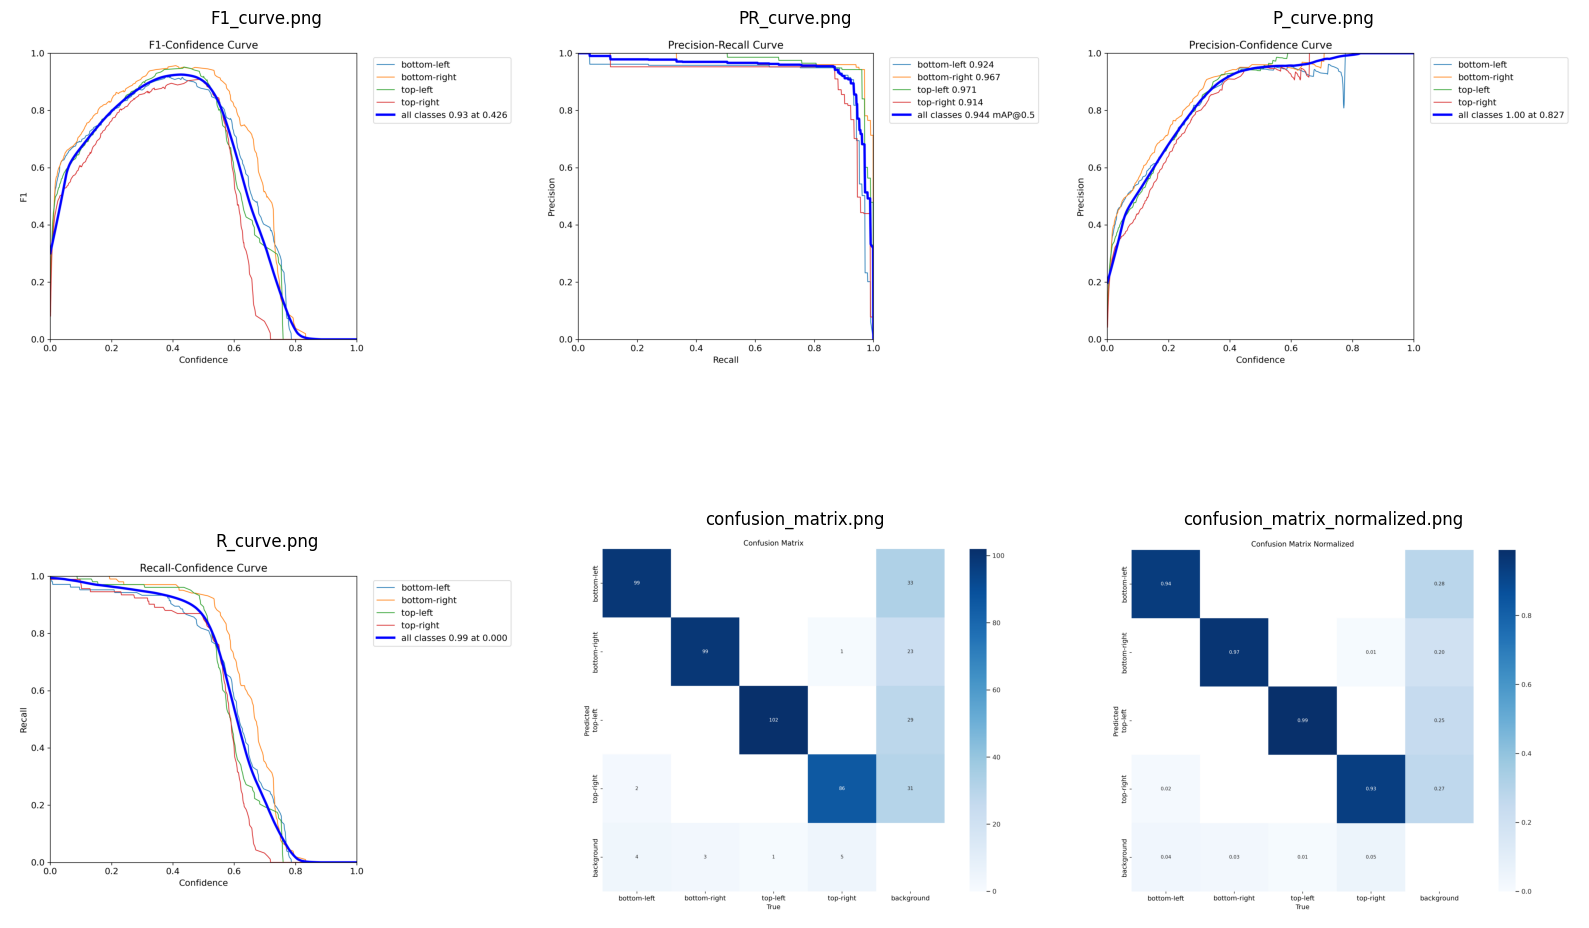

In [255]:
corner_detector.plot_val_results(data=CORNER_DATA_PATH)

#### 2.2 Đánh giá mô hình phát hiện vùng văn bản mặt trước CCCD

['front-field-project-runs/val/PR_curve.png', 'front-field-project-runs/val/R_curve.png', 'front-field-project-runs/val/P_curve.png', 'front-field-project-runs/val/F1_curve.png', 'front-field-project-runs/val/confusion_matrix.png', 'front-field-project-runs/val/confusion_matrix_normalized.png']


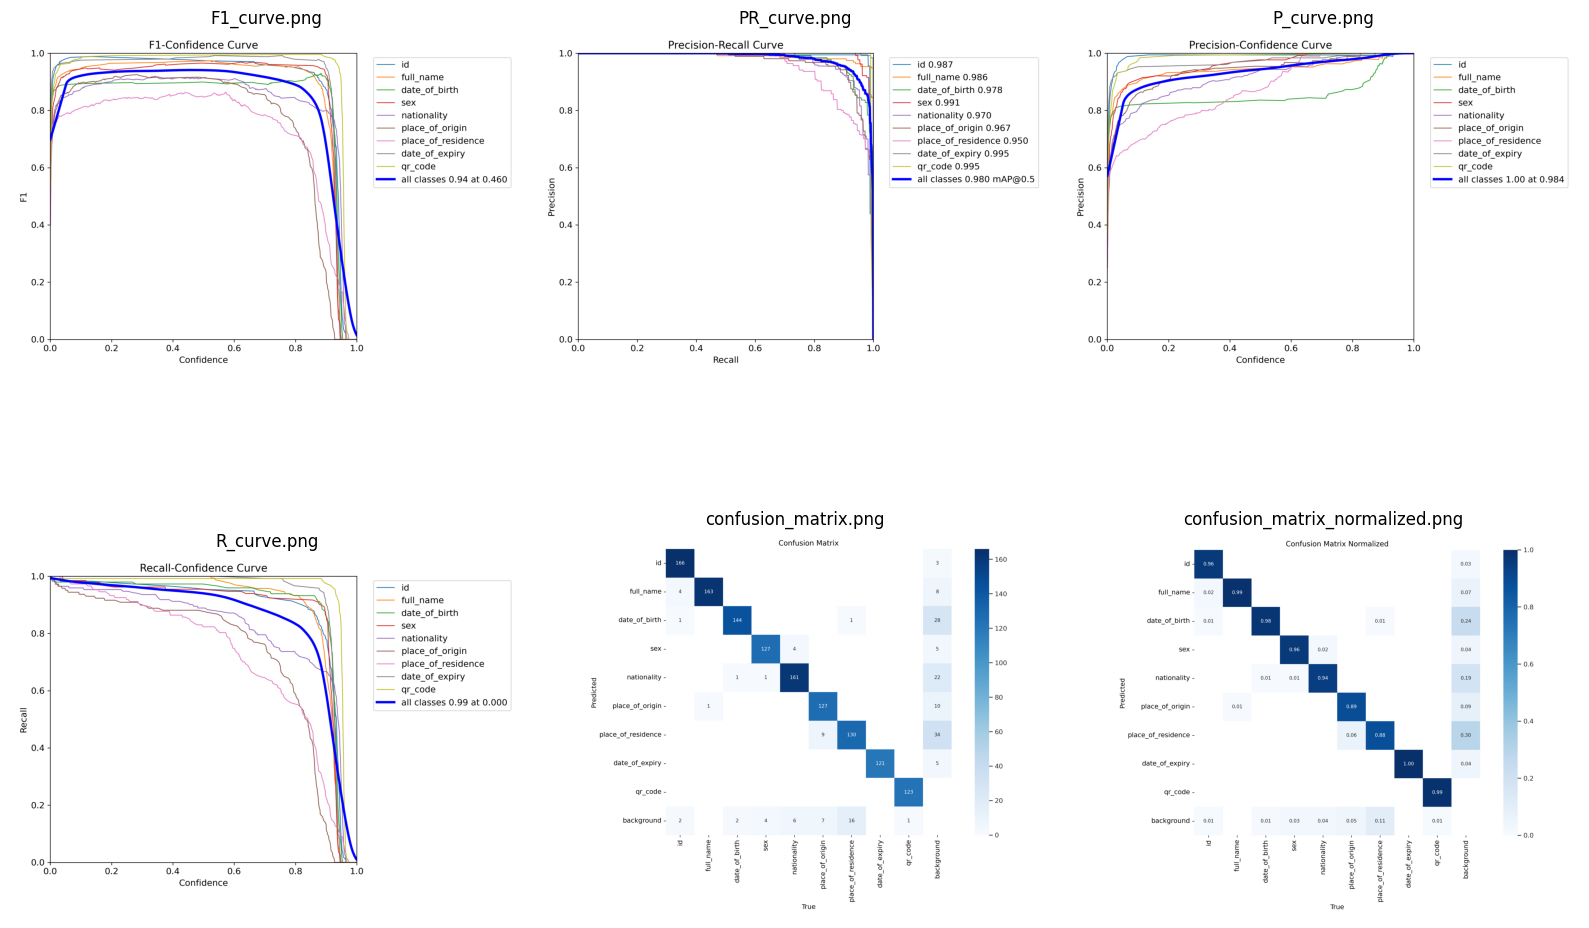

In [235]:
front_field_detector.plot_val_results(data=FRONT_FIELD_DATA_PATH)

#### 2.3 Đánh giá mô hình phát hiện vùng văn bản mặt sau CCCD

['back-field-project-runs/val/PR_curve.png', 'back-field-project-runs/val/R_curve.png', 'back-field-project-runs/val/P_curve.png', 'back-field-project-runs/val/F1_curve.png', 'back-field-project-runs/val/confusion_matrix.png', 'back-field-project-runs/val/confusion_matrix_normalized.png']


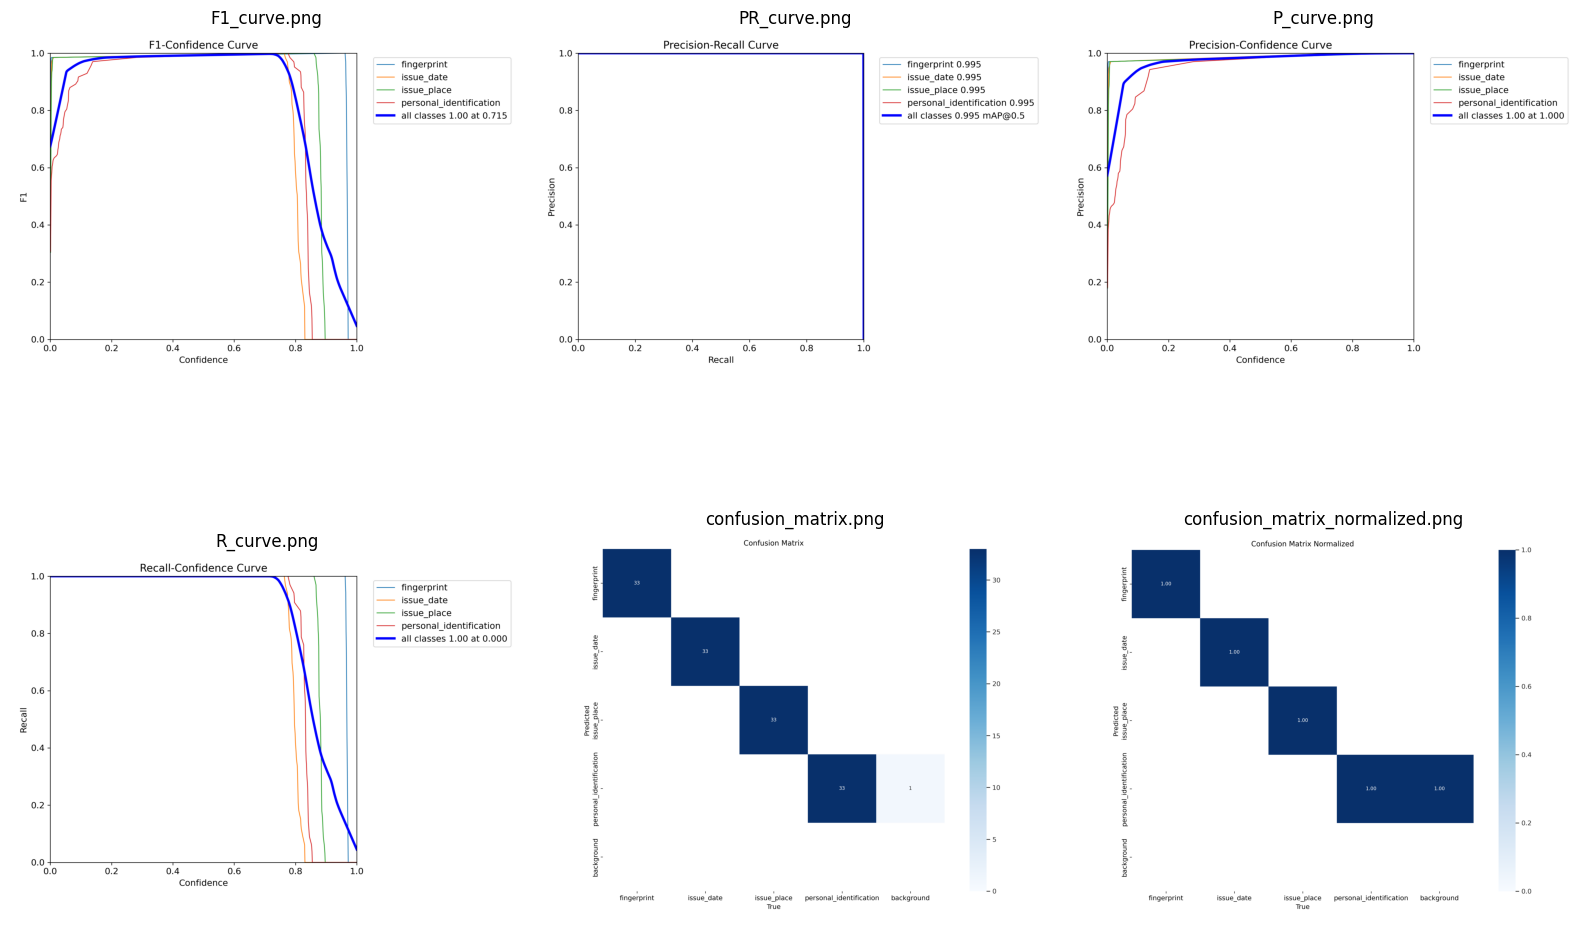

In [244]:
back_field_detector.plot_val_results(BACK_FIELD_DATA_PATH)

### 3. Hiển thị hình ảnh CCCD kèm bounding box


In [256]:
def draw_bounding(result, img, detector):
    drawed_img = img.copy()
    best_boxes = {}
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0].item()
        class_id = int(box.cls[0])
        class_name = detector.get_model().names[class_id]
        label = f"{class_name}: {confidence:.2f}"

        if class_id not in best_boxes or best_boxes[class_id]['confidence'] < confidence:
            best_boxes[class_id] = {
                'bbox': (x1, y1, x2, y2),
                'confidence': confidence,
                'label': f"{class_name}: {confidence:.2f}"
            }

            cv2.rectangle(drawed_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(drawed_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return drawed_img

#### 3.1 Kết quả nhận diện góc

In [ ]:
original_img = cv2.imread('')

corner_result = corner_detector.predict(img)

#### 3.2 Kết quả nhận diện vùng văn bản mặt trước

#### 3.3 Kết quả nhận diện vùng văn bản mặt sau

## VII. Nhận dạng kí tự
### 1. Nhận dạng kí tự Tesseract

In [58]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

### 2. Nhận dạng kí tự Vietocr

In [57]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

### 3. So sánh Tesseract và Vietocr

### 4. Kết quả trích xuất Căn cước công dân

## VIII. Ứng dụng và triển khai thực tế
### 1. Kiến trúc hệ thống
Hệ thống gồm 2 thành phần chính:
<ul>
    <li>Frontend (VueJS)</li>
    <li>Backend (FastAPI)</li>
</ul>

Đường dẫn ứng dụng: <a href="https://ocr.pgonevn.com">https://ocr.pgonevn.com</a></br>
Mã nguồn: <a href="https://github.com/ngquochuydl23/VietnameseIDCard">https://github.com/ngquochuydl23/VietnameseIDCard</a>

### 2. Hình ảnh Demo
#### 2.1 Trang chủ
![image](./screenshots/screenshot_1.png)

#### 2.2 Kết quả
21112801 - Nguyễn Quốc Huy
![image](./screenshots/screenshot_2.png)

21111531 - Lê Thị Thu Hương
![image](./screenshots/screenshot_3.png)

## IX. Kết luận và Hướng phát triển
### 1. Kết luận
- Tổng kết lại
    - Bài toán đã giải quyết được những gì?
    - Các bước xử lý (xác định góc, vùng chữ, OCR).
    - Mô hình sử dụng (YOLOv8, OCR model...).
    - Kết quả đạt được (các chỉ số đánh giá, quan sát trực quan).
- Nhấn mạnh những điểm mạnh của hệ thống.
### 2. Hạn chế
- Mô hình còn nhận diện sai về trường dữ liệu.
- Nhận dạng kí tự tiếng Việt chưa được chính xác.
- Thời gian trích xuất thông tin căn cước công dân chưa nhanh.
### 3. Hướng phát triển
- Cải thiện mô hình:
    - Dùng mô hình mạnh hơn (ví dụ TrOCR thay vì CRNN).
    - Fine-tune thêm với dữ liệu thực tế.

- Tăng chất lượng dữ liệu:

    - Bổ sung ảnh từ môi trường thực tế, đa dạng ngôn ngữ/font/kích thước.

## X. Tài liệu tham khảo

[(https://docs.ultralytics.com/vi/models/yolov8/)](https://docs.ultralytics.com/vi/models/yolov8/)

[(https://miai.vn/2020/07/04/co-ban-ve-object-detection-voi-r-cnn-fast-r-cnn-faster-r-cnn-va-yolo/)](https://miai.vn/2020/07/04/co-ban-ve-object-detection-voi-r-cnn-fast-r-cnn-faster-r-cnn-va-yolo/)

[(https://cmcts.com.vn/vi/nhan-dien-the-cccd-gan-chip.html)](https://cmcts.com.vn/vi/nhan-dien-the-cccd-gan-chip.html)

[(https://github.com/pbcquoc/vietocr)](https://github.com/pbcquoc/vietocr)
